# Class For DecisionTree

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioDecisionTreeClassifier:
    """
    A reusable Decision Tree classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, max_depth=None,
                 min_samples_split=2, min_samples_leaf=1, scale_features=True,
                 target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        max_depth : int, default=None
            Maximum depth of the tree
        min_samples_split : int, default=2
            Minimum samples required to split a node
        min_samples_leaf : int, default=1
            Minimum samples required at a leaf node
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """
        
        self.test_size = test_size
        self.random_state = random_state
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Decision Tree classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            random_state=self.random_state
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioDecisionTreeClassifier(
        test_size=0.2,
        random_state=42,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_decisiontree = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='cardio_train_pred.csv'
    )


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7211
Precision: 0.7326
Recall:    0.6865
F1-Score:  0.7088

Confusion Matrix:
[[5231 1698]
 [2124 4651]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.75      0.73      6929
     Disease       0.73      0.69      0.71      6775

    accuracy                           0.72     13704
   macro avg       0.72      0.72      0.72     13704
weighted avg       0.72      0.72      0.72     13704


Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7211
Precision: 0.7326
Recall:    0.6865
F1-Score:  0.7088

Confusion Matrix:
[[5231 1698]
 [2124 4651]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.75      0.73      6929
     Disease       0.73      0.69   

# Logistic Regression


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioLogisticRegressionClassifier:
    """
    A reusable Logistic Regression classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, C=1.0, 
                 solver='lbfgs', max_iter=100, scale_features=True,
                 target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        C : float, default=1.0
            Inverse of regularization strength; smaller values specify stronger regularization
        solver : str, default='lbfgs'
            Algorithm to use in the optimization problem
        max_iter : int, default=100
            Maximum number of iterations taken for the solvers to converge
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.test_size = test_size
        self.random_state = random_state
        self.C = C
        self.solver = solver
        self.max_iter = max_iter
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Logistic Regression classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = LogisticRegression(
            C=self.C,
            solver=self.solver,
            max_iter=self.max_iter,
            random_state=self.random_state
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioLogisticRegressionClassifier(
        test_size=0.3,
        random_state=12,
        C=1.0,
        solver='lbfgs',
        max_iter=10000, # Increased max_iter for convergence
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_logisticregression = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_LogisticRegression.csv' # Changed output name
    )
    print(matrix_logisticregression)


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 47964, Test size = 20556
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7250
Precision: 0.7508
Recall:    0.6642
F1-Score:  0.7049

Confusion Matrix:
[[8153 2240]
 [3413 6750]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.70      0.78      0.74     10393
     Disease       0.75      0.66      0.70     10163

    accuracy                           0.72     20556
   macro avg       0.73      0.72      0.72     20556
weighted avg       0.73      0.72      0.72     20556


Predictions exported to: Prediction_LogisticRegression.csv
Pipeline completed successfully!
{'accuracy': 0.7249951352403191, 'precision': 0.7508342602892102, 'recall': 0.6641739643805963, 'f1_score': 0.7048504150785778, 'confusion_matrix': array([[8153, 2240],
       [3413, 6750]])}
Predictions exported to: Prediction_LogisticRegression.csv

# Random Forest


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioRandomForestClassifier:
    """
    A reusable Random Forest classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, n_estimators=100, 
                 max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                 scale_features=True, target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        n_estimators : int, default=100
            Number of trees in the forest
        max_depth : int, default=None
            Maximum depth of the tree
        min_samples_split : int, default=2
            Minimum samples required to split a node
        min_samples_leaf : int, default=1
            Minimum samples required at a leaf node
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.test_size = test_size
        self.random_state = random_state
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Random Forest classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            random_state=self.random_state
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioRandomForestClassifier(
        test_size=0.2,
        random_state=42,
        n_estimators=100,
        max_depth=1000,
        min_samples_split=20,
        min_samples_leaf=10,
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_randomforest = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_RandomForest.csv' # Changed output name
    )


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7299
Precision: 0.7464
Recall:    0.6869
F1-Score:  0.7154

Confusion Matrix:
[[5348 1581]
 [2121 4654]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.72      0.77      0.74      6929
     Disease       0.75      0.69      0.72      6775

    accuracy                           0.73     13704
   macro avg       0.73      0.73      0.73     13704
weighted avg       0.73      0.73      0.73     13704


Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7299
Precision: 0.7464
Recall:    0.6869
F1-Score:  0.7154

Confusion Matrix:
[[5348 1581]
 [2121 4654]]

Classification Report:
              precision    recall  f1-s

# Naive Base


In [4]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioNaiveBayesClassifier:
    """
    A reusable Naive Bayes classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, var_smoothing=1e-9, 
                 scale_features=True, target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        var_smoothing : float, default=1e-9
            Portion of the largest variance of all features that is added to variances for calculation stability
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.test_size = test_size
        self.random_state = random_state
        self.var_smoothing = var_smoothing
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Naive Bayes classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = GaussianNB(
            var_smoothing=self.var_smoothing
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioNaiveBayesClassifier(
        test_size=0.2,
        random_state=42,
        var_smoothing=1e-9,
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_naivebayes = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_NaiveBayes.csv' # Changed output name
    )


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7072
Precision: 0.7501
Recall:    0.6114
F1-Score:  0.6737

Confusion Matrix:
[[5549 1380]
 [2633 4142]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.68      0.80      0.73      6929
     Disease       0.75      0.61      0.67      6775

    accuracy                           0.71     13704
   macro avg       0.71      0.71      0.70     13704
weighted avg       0.71      0.71      0.70     13704


Predictions exported to: Prediction_NaiveBayes.csv
Pipeline completed successfully!
Predictions exported to: Prediction_NaiveBayes.csv
Pipeline completed successfully!


# Gradient Boosting


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioGradientBoostingClassifier:
    """
    A reusable Gradient Boosting classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, n_estimators=100, 
                 learning_rate=0.1, max_depth=3, scale_features=True,
                 target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        n_estimators : int, default=100
            The number of boosting stages to perform
        learning_rate : float, default=0.1
            Learning rate shrinks the contribution of each tree by learning_rate
        max_depth : int, default=3
            Maximum depth of the individual regression estimators
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.test_size = test_size
        self.random_state = random_state
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Gradient Boosting classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = GradientBoostingClassifier(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            random_state=self.random_state
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioGradientBoostingClassifier(
        test_size=0.2,
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=10,
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_gradientboosting = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_GradientBoosting.csv' # Changed output name
    )


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7248
Precision: 0.7400
Recall:    0.6832
F1-Score:  0.7105

Confusion Matrix:
[[5303 1626]
 [2146 4629]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.77      0.74      6929
     Disease       0.74      0.68      0.71      6775

    accuracy                           0.72     13704
   macro avg       0.73      0.72      0.72     13704
weighted avg       0.73      0.72      0.72     13704


Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7248
Precision: 0.7400
Recall:    0.6832
F1-Score:  0.7105

Confusion Matrix:
[[5303 1626]
 [2146 4629]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.77      0.74      6929
     Disease       0.74      0.68   

# SVM 


In [6]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioSupportVectorClassifier:
    """
    A reusable Support Vector Machine classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, C=1.0, 
                 kernel='rbf', gamma='scale', scale_features=True,
                 target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        C : float, default=1.0
            Regularization parameter. The strength of the regularization is inversely proportional to C
        kernel : str, default='rbf'
            Specifies the kernel type to be used in the algorithm
        gamma : float or str, default='scale'
            Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.test_size = test_size
        self.random_state = random_state
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Support Vector Machine classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = SVC(
            C=self.C,
            kernel=self.kernel,
            gamma=self.gamma,
            random_state=self.random_state
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioSupportVectorClassifier(
        test_size=0.2,
        random_state=42,
        C=1.0,
        kernel='rbf',
        gamma='scale',
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_svm = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_SVM.csv' 
    )


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7328
Precision: 0.7605
Recall:    0.6707
F1-Score:  0.7128

Confusion Matrix:
[[5498 1431]
 [2231 4544]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.79      0.75      6929
     Disease       0.76      0.67      0.71      6775

    accuracy                           0.73     13704
   macro avg       0.74      0.73      0.73     13704
weighted avg       0.74      0.73      0.73     13704



MODEL PERFORMANCE METRICS
Accuracy:  0.7328
Precision: 0.7605
Recall:    0.6707
F1-Score:  0.7128

Confusion Matrix:
[[5498 1431]
 [2231 4544]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.79      0.75      6929
     Disease       0.76      0.67   

# KNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioKNeighborsClassifier:
    """
    A reusable K-Nearest Neighbors classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with configurable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean', 
                 scale_features=True, target_col='cardio', drop_cols=None,
                 test_size=0.2, random_state=42):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        n_neighbors : int, default=5
            Number of neighbors to use by default for kneighbors queries
        weights : str, default='uniform'
            Weight function used in prediction
        metric : str, default='euclidean'
            Distance metric to use for the tree
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        test_size : float, default=0.2
            Proportion of dataset to include in test split (0.2 = 20%)
        random_state : int, default=42
            Random seed for reproducibility
        """

        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        self.test_size = test_size
        self.random_state = random_state
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        Performs train-test split based on test_size parameter.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        # Perform train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        train_pct = (1 - self.test_size) * 100
        test_pct = self.test_size * 100
        print(f"Data preprocessed: Train set = {len(self.X_train)} samples ({train_pct:.0f}%), Test set = {len(self.X_test)} samples ({test_pct:.0f}%)")
    
    def train(self):
        """Train the K-Nearest Neighbors classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = KNeighborsClassifier(
            n_neighbors=self.n_neighbors,
            weights=self.weights,
            metric=self.metric
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses training set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_train
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if self.X_test is None:
            raise ValueError("No test data available. Check preprocess_data() was called.")
        
        # Predictions on test set
        y_pred = self.model.predict(self.X_test)
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS (Test Set)")
        print("="*50)
        print(f"Test Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision:      {self.metrics['precision']:.4f}")
        print(f"Recall:         {self.metrics['recall']:.4f}")
        print(f"F1-Score:       {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics (confusion matrix)
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with 80/20 train-test split
    clf = CardioKNeighborsClassifier(
        n_neighbors=5,
        weights='uniform',
        metric='euclidean',
        scale_features=True,
        target_col='cardio',
        drop_cols=['id'],
        test_size=0.2,  # 80/20 split
        random_state=42
    )
    
    # Run the pipeline and store confusion matrix in matrix_knn
    metrics = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_KNN.csv'
    )
    
    # Extract confusion matrix and accuracy
    matrix_knn = metrics['confusion_matrix']
    test_accuracy = metrics['accuracy']
    
    print("\nConfusion Matrix (matrix_knn):")
    print(matrix_knn)
    print(f"\nTest Set Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Training on entire dataset with 68520 samples
Model trained successfully!
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7830
Precision: 0.7860
Recall:    0.7709
F1-Score:  0.7784

Confusion Matrix:
[[27534  7109]
 [ 7760 26117]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.78      0.79      0.79     34643
     Disease       0.79      0.77      0.78     33877

    accuracy                           0.78     68520
   macro avg       0.78      0.78      0.78     68520
weighted avg       0.78      0.78      0.78     68520



MODEL PERFORMANCE METRICS
Accuracy:  0.7830
Precision: 0.7860
Recall:    0.7709
F1-Score:  0.7784

Confusion Matrix:
[[27534  7109]
 [ 7760 26117]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.78      0.79      0.79     34643
     Disease       0

# DL Algorithms


In [8]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioMLPClassifier:
    """
    A reusable Multi-Layer Perceptron (MLP) deep learning classifier for cardiovascular disease prediction using PyTorch.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, hidden_sizes=[64, 32], 
                 lr=0.001, epochs=100, batch_size=32, scale_features=True):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        hidden_sizes : list, default=[64, 32]
            List of hidden layer sizes
        lr : float, default=0.001
            Learning rate for the optimizer
        epochs : int, default=100
            Number of training epochs
        batch_size : int, default=32
            Batch size for training
        scale_features : bool, default=True
            Whether to scale features
        """

        self.test_size = test_size
        self.random_state = random_state
        self.hidden_sizes = hidden_sizes
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.scale_features = scale_features
        
        self.model = None
        self.scaler = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_tensor = None
        self.y_train_tensor = None
        self.feature_names = None
        self.metrics = {}
        self.drop_cols = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self, target_col='cardio', drop_cols=None):
        """
        Preprocess the data for training.
        
        Parameters:
        -----------
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        self.drop_cols = drop_cols if drop_cols else []
        
        df = self.data.copy()
        if drop_cols:
            df = df.drop(columns=drop_cols, errors='ignore')
        
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the MLP classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(self.X_train.values).to(self.device)
        y_train_tensor = torch.LongTensor(self.y_train.values).to(self.device)
        
        self.X_train_tensor = X_train_tensor
        self.y_train_tensor = y_train_tensor
        
        # Define model
        input_size = len(self.feature_names)
        layers = []
        prev_size = input_size
        for size in self.hidden_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            prev_size = size
        layers.append(nn.Linear(prev_size, 2))  # Binary classification
        
        self.model = nn.Sequential(*layers).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        # DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        self.model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            if (epoch + 1) % 50 == 0:
                avg_loss = running_loss / len(train_loader)
                print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.4f}')
        
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        self.model.eval()
        with torch.no_grad():
            if X is None:
                input_tensor = torch.FloatTensor(self.X_test.values).to(self.device)
            else:
                if self.scale_features and self.scaler is not None:
                    X_scaled = pd.DataFrame(
                        self.scaler.transform(X),
                        columns=X.columns,
                        index=X.index
                    )
                    input_tensor = torch.FloatTensor(X_scaled.values).to(self.device)
                else:
                    input_tensor = torch.FloatTensor(X.values).to(self.device)
            
            outputs = self.model(input_tensor)
            _, predicted = torch.max(outputs.data, 1)
            return predicted.cpu().numpy()
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                   target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
        
        X_full = X_full.drop(columns=['cardio'], errors='ignore')
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.predict(X_full_scaled)
        else:
            predictions = self.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df['cardio'] = self.data['cardio']
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, 
                         target_col='cardio', drop_cols=None):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        target_col : str, default='cardio'
            Name of target variable
        drop_cols : list, default=None
            Columns to drop before training
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data(target_col=target_col, drop_cols=drop_cols)
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath)
        
        print("Pipeline completed successfully!")
        return metrics


class CardioTabularCNNClassifier:
    """
    A reusable 1D Convolutional Neural Network (CNN) classifier for tabular cardiovascular disease prediction using PyTorch.
    Treats features as a 1D sequence.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, filters=[32, 64], 
                 kernel_sizes=[3, 3], lr=0.001, epochs=100, batch_size=32, 
                 scale_features=True):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        filters : list, default=[32, 64]
            List of number of filters for each conv layer
        kernel_sizes : list, default=[3, 3]
            List of kernel sizes for each conv layer
        lr : float, default=0.001
            Learning rate for the optimizer
        epochs : int, default=100
            Number of training epochs
        batch_size : int, default=32
            Batch size for training
        scale_features : bool, default=True
            Whether to scale features
        """

        self.test_size = test_size
        self.random_state = random_state
        self.filters = filters
        self.kernel_sizes = kernel_sizes
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.scale_features = scale_features
        
        self.model = None
        self.scaler = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_tensor = None
        self.y_train_tensor = None
        self.feature_names = None
        self.metrics = {}
        self.drop_cols = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self, target_col='cardio', drop_cols=None):
        """
        Preprocess the data for training.
        
        Parameters:
        -----------
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        self.drop_cols = drop_cols if drop_cols else []
        
        df = self.data.copy()
        if drop_cols:
            df = df.drop(columns=drop_cols, errors='ignore')
        
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Tabular CNN classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        # Convert to tensors with channel dimension for Conv1D
        X_train_tensor = torch.FloatTensor(self.X_train.values).unsqueeze(1).to(self.device)  # (N, 1, features)
        y_train_tensor = torch.LongTensor(self.y_train.values).to(self.device)
        
        self.X_train_tensor = X_train_tensor
        self.y_train_tensor = y_train_tensor
        
        # Define model
        input_size = len(self.feature_names)
        conv_layers = []
        prev_channels = 1
        prev_size = input_size
        for f, k in zip(self.filters, self.kernel_sizes):
            conv_layers.append(nn.Conv1d(prev_channels, f, kernel_size=k, padding=(k-1)//2))
            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.MaxPool1d(2))
            prev_channels = f
            prev_size = prev_size // 2  # Approximate after pooling
        
        # Flatten size calculation (approximate)
        flatten_size = prev_channels * (input_size // 4)  # Assuming two poolings halve twice
        
        self.model = nn.Sequential(
            *conv_layers,
            nn.Flatten(),
            nn.Linear(flatten_size, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        ).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        # DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        self.model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            if (epoch + 1) % 50 == 0:
                avg_loss = running_loss / len(train_loader)
                print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.4f}')
        
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        self.model.eval()
        with torch.no_grad():
            if X is None:
                input_tensor = torch.FloatTensor(self.X_test.values).unsqueeze(1).to(self.device)
            else:
                if self.scale_features and self.scaler is not None:
                    X_scaled = pd.DataFrame(
                        self.scaler.transform(X),
                        columns=X.columns,
                        index=X.index
                    )
                    input_tensor = torch.FloatTensor(X_scaled.values).unsqueeze(1).to(self.device)
                else:
                    input_tensor = torch.FloatTensor(X.values).unsqueeze(1).to(self.device)
            
            outputs = self.model(input_tensor)
            _, predicted = torch.max(outputs.data, 1)
            return predicted.cpu().numpy()
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                   target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
        
        X_full = X_full.drop(columns=['cardio'], errors='ignore')
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.predict(X_full_scaled)
        else:
            predictions = self.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df['cardio'] = self.data['cardio']
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, 
                         target_col='cardio', drop_cols=None):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        target_col : str, default='cardio'
            Name of target variable
        drop_cols : list, default=None
            Columns to drop before training
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data(target_col=target_col, drop_cols=drop_cols)
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # MLP Example
    print("Running MLP Pipeline...")
    mlp_clf = CardioMLPClassifier(
        test_size=0.2,
        random_state=42,
        hidden_sizes=[64, 32],
        lr=0.001,
        epochs=100,
        batch_size=32,
        scale_features=True
    )
    
    matrix_mlp = mlp_clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_MLP.csv',
        drop_cols=['id'] 
    )
    
    # CNN Example
    # print("\nRunning Tabular CNN Pipeline...")
    # cnn_clf = CardioTabularCNNClassifier(
    #     test_size=0.2,
    #     random_state=42,
    #     filters=[32, 64],
    #     kernel_sizes=[3, 3],
    #     lr=0.001,
    #     epochs=100,
    #     batch_size=32,
    #     scale_features=True
    # )
    
    # cnn_metrics = cnn_clf.run_full_pipeline(
    #     input_filepath='cardio_train.csv',
    #     output_filepath='cardio_train_cnn_pred.csv',
    #     drop_cols=['id'] 
    # )

ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for torchaudio


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
Running MLP Pipeline...
Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Running MLP Pipeline...
Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Epoch [50/100], Loss: 0.5279
Epoch [50/100], Loss: 0.5279
Epoch [100/100], Loss: 0.5181
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7229
Precision: 0.7469
Recall:    0.6646
F1-Score:  0.7034

Confusion Matrix:
[[5403 1526]
 [2272 4503]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.70      0.78      0.74      6929
     Disease       0.75      0.66      0.70      6775

    accuracy                           0.72     13704
   macro avg       0.73      0.72      0.72     13704
weig

# Final Voted Ensamble algorithm


In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Model configuration with all metrics provided by user
models_config = {
    'LogisticRegression': {
        'file': 'Prediction_LogisticRegression.csv',
        'metrics': matrix_logisticregression
    },
    'RandomForest': {
        'file': 'Prediction_RandomForest.csv',
        'metrics': matrix_randomforest
    },
    'NaiveBayes': {
        'file': 'Prediction_NaiveBayes.csv',
        'metrics': matrix_naivebayes
    },
    'GradientBoosting': {
        'file': 'Prediction_GradientBoosting.csv',
        'metrics': matrix_gradientboosting
    },
    'SVM': {
        'file': 'Prediction_SVM.csv',
        'metrics': matrix_svm
    },
    'KNN': {
        'file': 'Prediction_KNN.csv',
        'metrics': {
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1_score': metrics['f1_score'],
            'confusion_matrix': matrix_knn
        }
    },
    'MLP': {
        'file': 'Prediction_MLP.csv',
        'metrics': matrix_mlp
    }
}

def load_predictions():
    """Load all prediction files and extract predicted column"""
    predictions_dict = {}
    base_df = None
    
    for model_name, config in models_config.items():
        try:
            df = pd.read_csv(config['file'])
            
            # Store base dataframe (all columns except predicted)
            if base_df is None:
                base_df = df.drop(columns=['predicted']) if 'predicted' in df.columns else df.copy()
            
            # Extract predictions
            if 'predicted' in df.columns:
                predictions_dict[model_name] = df['predicted'].values
                print(f"✓ Loaded {model_name}: {len(df)} predictions")
            else:
                print(f"✗ Warning: 'predicted' column not found in {config['file']}")
                
        except FileNotFoundError:
            print(f"✗ Warning: File {config['file']} not found. Skipping {model_name}.")
        except Exception as e:
            print(f"✗ Error loading {config['file']}: {str(e)}")
    
    return base_df, predictions_dict

def majority_voting_simple(predictions_dict):
    """
    Perform simple majority voting (most votes wins)
    
    Args:
        predictions_dict: Dictionary of model predictions
    
    Returns:
        final_predictions: Array of final predictions
    """
    n_samples = len(next(iter(predictions_dict.values())))
    
    # Stack all predictions into a matrix (n_samples x n_models)
    predictions_matrix = np.column_stack(list(predictions_dict.values()))
    
    # For each sample, count votes for class 1
    votes_for_1 = np.sum(predictions_matrix, axis=1)
    
    # Majority vote: if more than half vote for 1, predict 1
    n_models = len(predictions_dict)
    final_predictions = (votes_for_1 > n_models / 2).astype(int)
    
    return final_predictions

def weighted_voting(predictions_dict, models_config):
    """
    Perform weighted voting based on model accuracies
    
    Args:
        predictions_dict: Dictionary of model predictions
        models_config: Configuration with accuracy metrics
    
    Returns:
        final_predictions: Array of final predictions
        weights: Dictionary of normalized weights
    """
    # Extract accuracies and create weights
    weights = {}
    for model_name in predictions_dict.keys():
        accuracy = models_config[model_name]['metrics']['accuracy']
        weights[model_name] = accuracy
    
    # Normalize weights to sum to 1
    total_weight = sum(weights.values())
    normalized_weights = {k: v/total_weight for k, v in weights.items()}
    
    print("\n=== Model Weights (Based on Accuracy) ===")
    for model, weight in sorted(normalized_weights.items(), key=lambda x: x[1], reverse=True):
        print(f"{model}: {weight:.4f} (Accuracy: {models_config[model]['metrics']['accuracy']:.4f})")
    
    # Perform weighted voting
    n_samples = len(next(iter(predictions_dict.values())))
    weighted_votes = np.zeros(n_samples)
    
    for model_name, predictions in predictions_dict.items():
        weight = normalized_weights[model_name]
        weighted_votes += predictions * weight
    
    # Final prediction: if weighted vote >= 0.5, predict 1, else 0
    final_predictions = (weighted_votes >= 0.5).astype(int)
    
    return final_predictions, normalized_weights

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

def main():
    print("=" * 70)
    print("ENSEMBLE PREDICTION - MAJORITY VOTING FROM ALL ALGORITHMS")
    print("=" * 70)
    
    # Load all predictions
    print("\n📂 STEP 1: Loading prediction files...")
    print("-" * 70)
    base_df, predictions_dict = load_predictions()
    
    if not predictions_dict:
        print("\n❌ Error: No prediction files loaded successfully.")
        print("Please ensure all prediction CSV files are in the current directory.")
        return
    
    print(f"\n✓ Successfully loaded {len(predictions_dict)} model predictions")
    print(f"✓ Number of samples: {len(next(iter(predictions_dict.values())))}")
    
    # Perform simple majority voting
    print("\n" + "=" * 70)
    print("📊 STEP 2: Performing SIMPLE MAJORITY VOTING...")
    print("-" * 70)
    print("Each model gets 1 vote. Prediction with most votes wins.")
    
    simple_predictions = majority_voting_simple(predictions_dict)
    
    # Perform weighted voting
    print("\n" + "=" * 70)
    print("⚖️  STEP 3: Performing WEIGHTED VOTING (by accuracy)...")
    print("-" * 70)
    
    weighted_predictions, weights = weighted_voting(predictions_dict, models_config)
    
    # Add both predictions to dataframe
    final_df = base_df.copy()
    final_df['predicted_simple_majority'] = simple_predictions
    final_df['predicted_weighted'] = weighted_predictions
    
    # Calculate ensemble metrics if ground truth is available
    if 'cardio' in final_df.columns:
        print("\n" + "=" * 70)
        print("📈 STEP 4: Evaluating Ensemble Performance...")
        print("=" * 70)
        
        # Metrics for simple majority
        simple_metrics = calculate_metrics(final_df['cardio'], simple_predictions)
        
        # Metrics for weighted voting
        weighted_metrics = calculate_metrics(final_df['cardio'], weighted_predictions)
        
        print("\n🎯 SIMPLE MAJORITY VOTING Performance:")
        print("-" * 70)
        print(f"Accuracy:  {simple_metrics['accuracy']:.4f}")
        print(f"Precision: {simple_metrics['precision']:.4f}")
        print(f"Recall:    {simple_metrics['recall']:.4f}")
        print(f"F1-Score:  {simple_metrics['f1_score']:.4f}")
        print(f"\nConfusion Matrix:")
        print(simple_metrics['confusion_matrix'])
        print(f"  TN: {simple_metrics['confusion_matrix'][0,0]:5d} | FP: {simple_metrics['confusion_matrix'][0,1]:5d}")
        print(f"  FN: {simple_metrics['confusion_matrix'][1,0]:5d} | TP: {simple_metrics['confusion_matrix'][1,1]:5d}")
        
        print("\n⚖️  WEIGHTED VOTING Performance:")
        print("-" * 70)
        print(f"Accuracy:  {weighted_metrics['accuracy']:.4f}")
        print(f"Precision: {weighted_metrics['precision']:.4f}")
        print(f"Recall:    {weighted_metrics['recall']:.4f}")
        print(f"F1-Score:  {weighted_metrics['f1_score']:.4f}")
        print(f"\nConfusion Matrix:")
        print(weighted_metrics['confusion_matrix'])
        print(f"  TN: {weighted_metrics['confusion_matrix'][0,0]:5d} | FP: {weighted_metrics['confusion_matrix'][0,1]:5d}")
        print(f"  FN: {weighted_metrics['confusion_matrix'][1,0]:5d} | TP: {weighted_metrics['confusion_matrix'][1,1]:5d}")
        
        # Compare with individual models
        print("\n" + "=" * 70)
        print("📊 COMPARISON: All Models vs Ensemble")
        print("=" * 70)
        
        comparison_data = []
        for model_name, config in models_config.items():
            if model_name in predictions_dict:
                comparison_data.append({
                    'Model': model_name,
                    'Accuracy': config['metrics']['accuracy'],
                    'Precision': config['metrics']['precision'],
                    'Recall': config['metrics']['recall'],
                    'F1-Score': config['metrics']['f1_score']
                })
        
        comparison_data.append({
            'Model': '─' * 25,
            'Accuracy': '',
            'Precision': '',
            'Recall': '',
            'F1-Score': ''
        })
        
        comparison_data.append({
            'Model': '🎯 SIMPLE MAJORITY',
            'Accuracy': simple_metrics['accuracy'],
            'Precision': simple_metrics['precision'],
            'Recall': simple_metrics['recall'],
            'F1-Score': simple_metrics['f1_score']
        })
        
        comparison_data.append({
            'Model': '⚖️  WEIGHTED ENSEMBLE',
            'Accuracy': weighted_metrics['accuracy'],
            'Precision': weighted_metrics['precision'],
            'Recall': weighted_metrics['recall'],
            'F1-Score': weighted_metrics['f1_score']
        })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        
        # Check improvements
        max_individual_accuracy = max([config['metrics']['accuracy'] for config in models_config.values()])
        simple_improvement = simple_metrics['accuracy'] - max_individual_accuracy
        weighted_improvement = weighted_metrics['accuracy'] - max_individual_accuracy
        
        print("\n" + "=" * 70)
        print("📈 IMPROVEMENT ANALYSIS:")
        print("-" * 70)
        print(f"Best Individual Model Accuracy: {max_individual_accuracy:.4f}")
        print(f"Simple Majority Improvement:    {simple_improvement:+.4f} ({simple_improvement*100:+.2f}%)")
        print(f"Weighted Voting Improvement:    {weighted_improvement:+.4f} ({weighted_improvement*100:+.2f}%)")
        
        # Determine best approach
        best_accuracy = max(simple_metrics['accuracy'], weighted_metrics['accuracy'])
        if simple_metrics['accuracy'] > weighted_metrics['accuracy']:
            print(f"\n🏆 WINNER: Simple Majority Voting")
            final_df['predicted'] = simple_predictions
            best_method = "Simple Majority"
        else:
            print(f"\n🏆 WINNER: Weighted Voting")
            final_df['predicted'] = weighted_predictions
            best_method = "Weighted"
    else:
        # No ground truth, use weighted voting as default
        final_df['predicted'] = weighted_predictions
        best_method = "Weighted"
    
    # Save final predictions
    output_file = 'Prediction_Ensemble_MajorityVoting.csv'
    final_df.to_csv(output_file, index=False)
    
    print("\n" + "=" * 70)
    print("💾 STEP 5: Saving Results...")
    print("-" * 70)
    print(f"✓ Final predictions saved to: {output_file}")
    print(f"✓ Best method used: {best_method} Voting")
    
    # Summary statistics
    print("\n" + "=" * 70)
    print("📋 PREDICTION SUMMARY")
    print("=" * 70)
    print(f"Total predictions: {len(final_df)}")
    
    for col in ['predicted_simple_majority', 'predicted_weighted', 'predicted']:
        if col in final_df.columns:
            pred = final_df[col]
            print(f"\n{col}:")
            print(f"  Cardio = 0 (Healthy):  {np.sum(pred == 0):5d} ({np.sum(pred == 0)/len(pred)*100:.2f}%)")
            print(f"  Cardio = 1 (Disease):  {np.sum(pred == 1):5d} ({np.sum(pred == 1)/len(pred)*100:.2f}%)")
    
    print("\n" + "=" * 70)
    print("✅ ENSEMBLE VOTING COMPLETED SUCCESSFULLY!")
    print("=" * 70)

if __name__ == "__main__":
    main()


ENSEMBLE PREDICTION - MAJORITY VOTING FROM ALL ALGORITHMS

📂 STEP 1: Loading prediction files...
----------------------------------------------------------------------
✓ Loaded LogisticRegression: 68520 predictions
✓ Loaded RandomForest: 68520 predictions
✓ Loaded NaiveBayes: 68520 predictions
✓ Loaded GradientBoosting: 68520 predictions
✓ Loaded SVM: 68520 predictions
✓ Loaded KNN: 68520 predictions
✓ Loaded MLP: 68520 predictions

✓ Successfully loaded 7 model predictions
✓ Number of samples: 68520

📊 STEP 2: Performing SIMPLE MAJORITY VOTING...
----------------------------------------------------------------------
Each model gets 1 vote. Prediction with most votes wins.

⚖️  STEP 3: Performing WEIGHTED VOTING (by accuracy)...
----------------------------------------------------------------------

=== Model Weights (Based on Accuracy) ===
KNN: 0.1528 (Accuracy: 0.7830)
SVM: 0.1430 (Accuracy: 0.7328)
RandomForest: 0.1424 (Accuracy: 0.7299)
LogisticRegression: 0.1415 (Accuracy: 0.7250)

# Performance Visualizations for All Classifiers

This section contains comprehensive performance graphs for each classifier including:
- Confusion Matrix Heatmaps
- ROC Curves
- Precision-Recall Curves
- Performance Metrics Comparison
- Feature Importance (where applicable)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                             precision_recall_curve, average_precision_score)
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Create Figures directory if it doesn't exist
import os
if not os.path.exists('Figures'):
    os.makedirs('Figures')
    print("Created 'Figures' directory")

print("Visualization libraries imported successfully!")

Visualization libraries imported successfully!


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title, ax=None):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    ax.set_title(f'Confusion Matrix - {title}', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    
    # Add accuracy metrics
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    ax.text(0.5, -0.15, f'Accuracy: {accuracy:.4f}', 
            ha='center', transform=ax.transAxes, fontsize=11)
    
    return ax

def plot_roc_curve(y_true, y_proba, title, ax=None):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
            label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curve - {title}', fontsize=14, fontweight='bold')
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)
    
    return ax

def plot_precision_recall_curve(y_true, y_proba, title, ax=None):
    """Plot Precision-Recall curve"""
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(recall, precision, color='blue', lw=2,
            label=f'PR curve (AP = {avg_precision:.4f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'Precision-Recall Curve - {title}', fontsize=14, fontweight='bold')
    ax.legend(loc="lower left", fontsize=10)
    ax.grid(True, alpha=0.3)
    
    return ax

def get_metric_value(metrics_dict, key):
    """Helper function to get metric value with flexible key matching"""
    # Try lowercase with underscore
    if key in metrics_dict:
        return metrics_dict[key]
    # Try capitalized
    if key.capitalize() in metrics_dict:
        return metrics_dict[key.capitalize()]
    # Try as-is
    return metrics_dict.get(key, 0)

def plot_metrics_comparison(metrics_dict, title):
    """Plot bar chart comparing different metrics"""
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [
        get_metric_value(metrics_dict, 'accuracy'),
        get_metric_value(metrics_dict, 'precision'),
        get_metric_value(metrics_dict, 'recall'),
        get_metric_value(metrics_dict, 'f1_score')
    ]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics, values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'],
                  alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_ylim([0, 1])
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'Performance Metrics - {title}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    return fig, ax

def plot_classifier_performance_grid(y_true, y_pred, y_proba, metrics_dict, title):
    """Create a 2x2 grid of performance plots for a classifier"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Comprehensive Performance Analysis - {title}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, title, axes[0, 0])
    
    # ROC Curve
    plot_roc_curve(y_true, y_proba, title, axes[0, 1])
    
    # Precision-Recall Curve
    plot_precision_recall_curve(y_true, y_proba, title, axes[1, 0])
    
    # Metrics Comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [
        get_metric_value(metrics_dict, 'accuracy'),
        get_metric_value(metrics_dict, 'precision'),
        get_metric_value(metrics_dict, 'recall'),
        get_metric_value(metrics_dict, 'f1_score')
    ]
    bars = axes[1, 1].bar(metrics, values, 
                          color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'],
                          alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1, 1].set_ylim([0, 1])
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].set_title('Performance Metrics', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{value:.4f}',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    return fig

print("Helper visualization functions defined successfully!")

Helper visualization functions defined successfully!


## 1. Decision Tree Classifier - Performance Visualization

**Note:** Make sure to run all previous cells to load the classifier classes before running the visualization cells below.

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7217
Precision: 0.7327
Recall:    0.6881
F1-Score:  0.7097

Confusion Matrix:
[[5228 1701]
 [2113 4662]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.75      0.73      6929
     Disease       0.73      0.69      0.71      6775

    accuracy                           0.72     13704
   macro avg       0.72      0.72      0.72     13704
weighted avg       0.72      0.72      0.72     13704




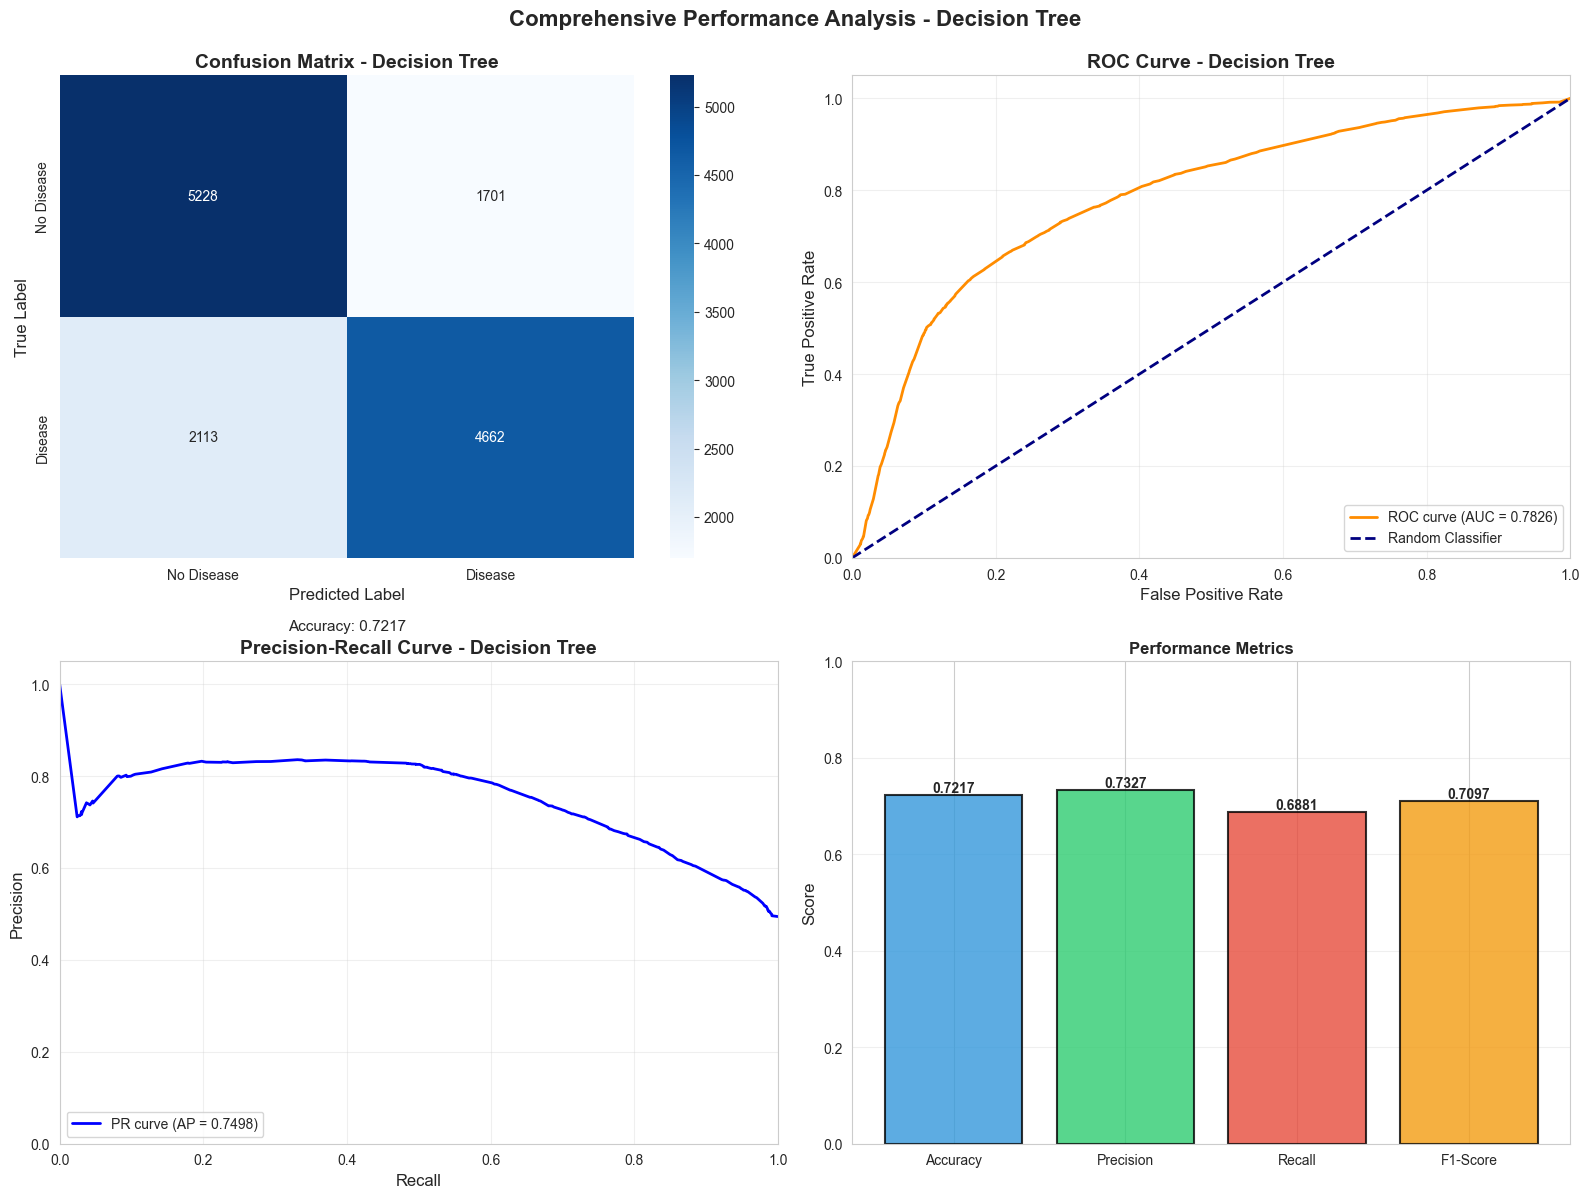


=== Decision Tree Performance Summary ===
Accuracy:  0.7217
Precision: 0.7327
Recall:    0.6881
F1-Score:  0.7097


In [ ]:
# Train Decision Tree and generate visualizations
dt_classifier = CardioDecisionTreeClassifier(
    test_size=0.2,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    scale_features=True
)

# Load and train
dt_classifier.load_data('train.csv')
dt_classifier.preprocess_data()
dt_classifier.train()

# Evaluate to get metrics
dt_classifier.evaluate()

# Get predictions and probabilities
y_pred = dt_classifier.model.predict(dt_classifier.X_test)
y_proba = dt_classifier.model.predict_proba(dt_classifier.X_test)[:, 1]

# Get metrics
dt_metrics = dt_classifier.metrics

# Create comprehensive performance visualization
fig = plot_classifier_performance_grid(
    dt_classifier.y_test, y_pred, y_proba, 
    dt_metrics, 'Decision Tree'
)
plt.savefig('Figures/DecisionTree_Performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Decision Tree Performance Summary ===")
print(f"Accuracy:  {dt_metrics['accuracy']:.4f}")
print(f"Precision: {dt_metrics['precision']:.4f}")
print(f"Recall:    {dt_metrics['recall']:.4f}")
print(f"F1-Score:  {dt_metrics['f1_score']:.4f}")

## 2. Logistic Regression - Performance Visualization

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7268
Precision: 0.7536
Recall:    0.6646
F1-Score:  0.7064

Confusion Matrix:
[[5457 1472]
 [2272 4503]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.79      0.74      6929
     Disease       0.75      0.66      0.71      6775

    accuracy                           0.73     13704
   macro avg       0.73      0.73      0.73     13704
weighted avg       0.73      0.73      0.73     13704




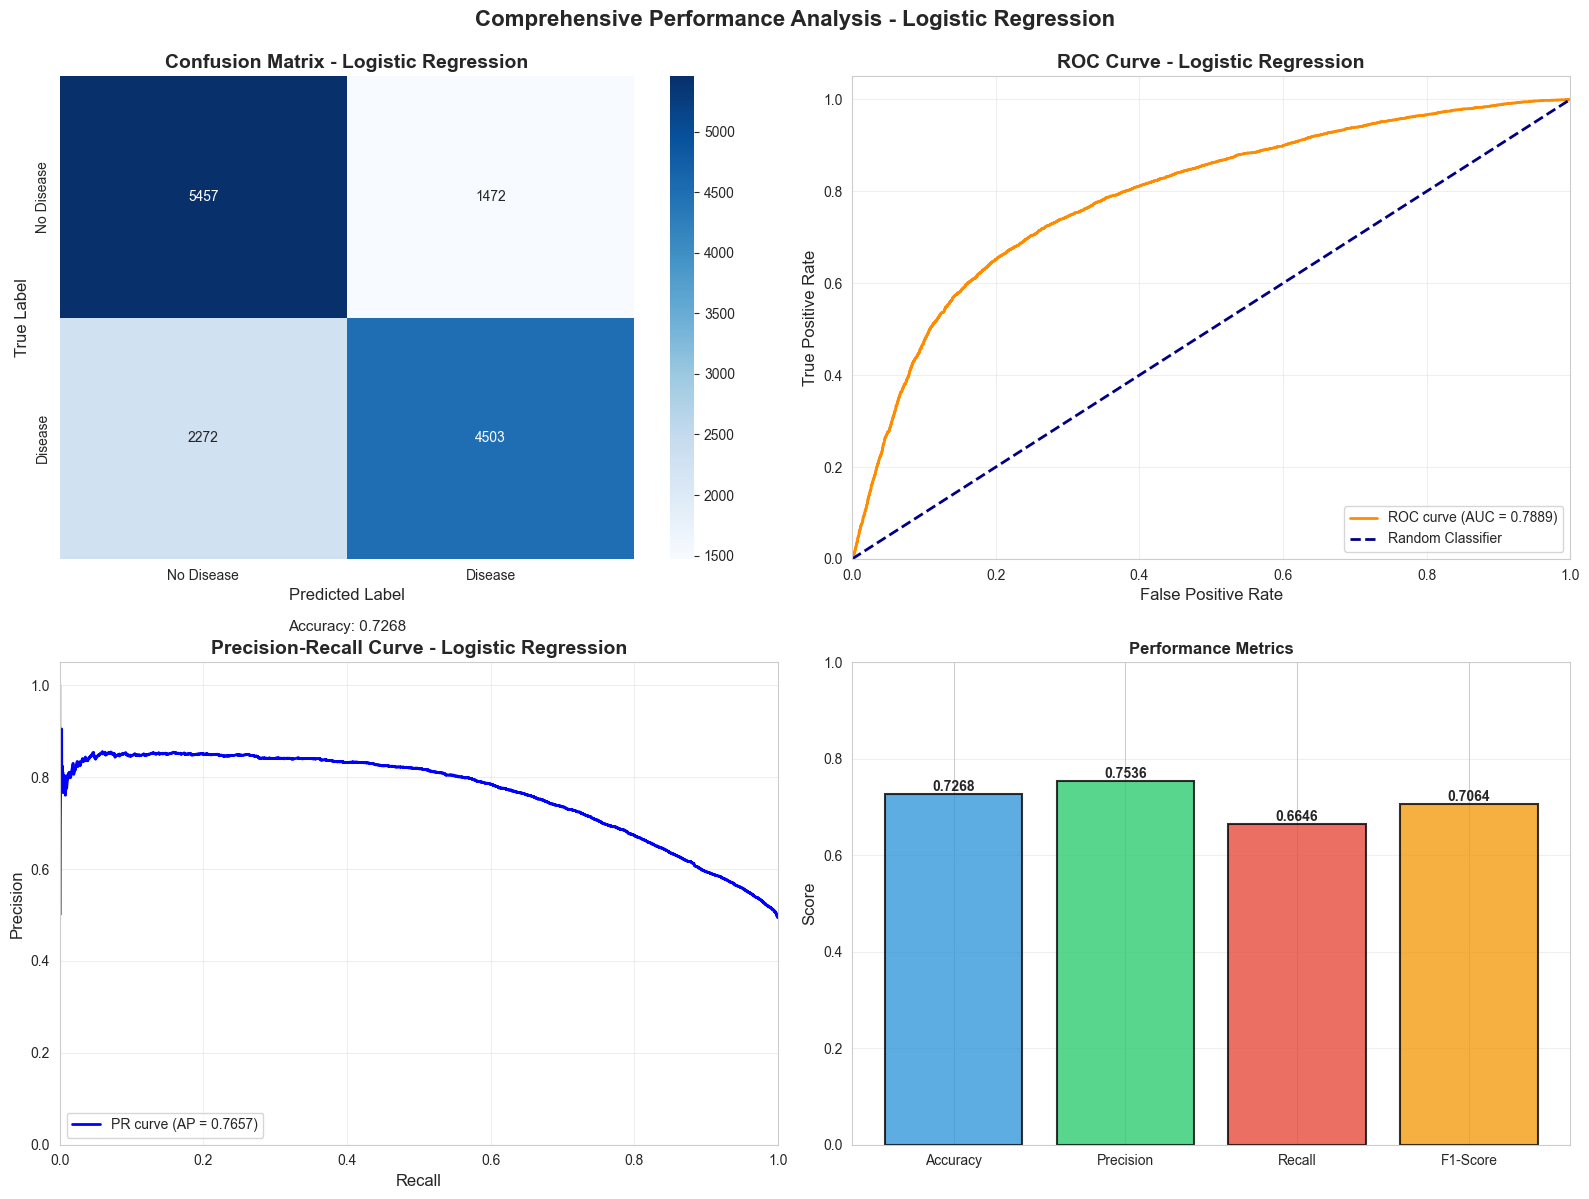


=== Logistic Regression Performance Summary ===
Accuracy:  0.7268
Precision: 0.7536
Recall:    0.6646
F1-Score:  0.7064


In [ ]:
# Train Logistic Regression and generate visualizations
lr_classifier = CardioLogisticRegressionClassifier(
    test_size=0.2,
    random_state=42,
    scale_features=True,
    max_iter=1000
)

# Load and train
lr_classifier.load_data('train.csv')
lr_classifier.preprocess_data()
lr_classifier.train()

# Evaluate to get metrics
lr_classifier.evaluate()

# Get predictions and probabilities
y_pred_lr = lr_classifier.model.predict(lr_classifier.X_test)
y_proba_lr = lr_classifier.model.predict_proba(lr_classifier.X_test)[:, 1]

# Get metrics
lr_metrics = lr_classifier.metrics

# Create comprehensive performance visualization
fig = plot_classifier_performance_grid(
    lr_classifier.y_test, y_pred_lr, y_proba_lr, 
    lr_metrics, 'Logistic Regression'
)
plt.savefig('Figures/LogisticRegression_Performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Logistic Regression Performance Summary ===")
print(f"Accuracy:  {lr_metrics['accuracy']:.4f}")
print(f"Precision: {lr_metrics['precision']:.4f}")
print(f"Recall:    {lr_metrics['recall']:.4f}")
print(f"F1-Score:  {lr_metrics['f1_score']:.4f}")

## 3. Random Forest - Performance Visualization

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7322
Precision: 0.7566
Recall:    0.6757
F1-Score:  0.7139

Confusion Matrix:
[[5456 1473]
 [2197 4578]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.79      0.75      6929
     Disease       0.76      0.68      0.71      6775

    accuracy                           0.73     13704
   macro avg       0.73      0.73      0.73     13704
weighted avg       0.73      0.73      0.73     13704


Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7322
Precision: 0.7566
Recall:    0.6757
F1-Score:  0.7139

Confusion Matrix:
[[5456 1473]
 [2197 4578]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.79      0.75      6929
     Disease       0.76      0.68      0.71      6775

    accu

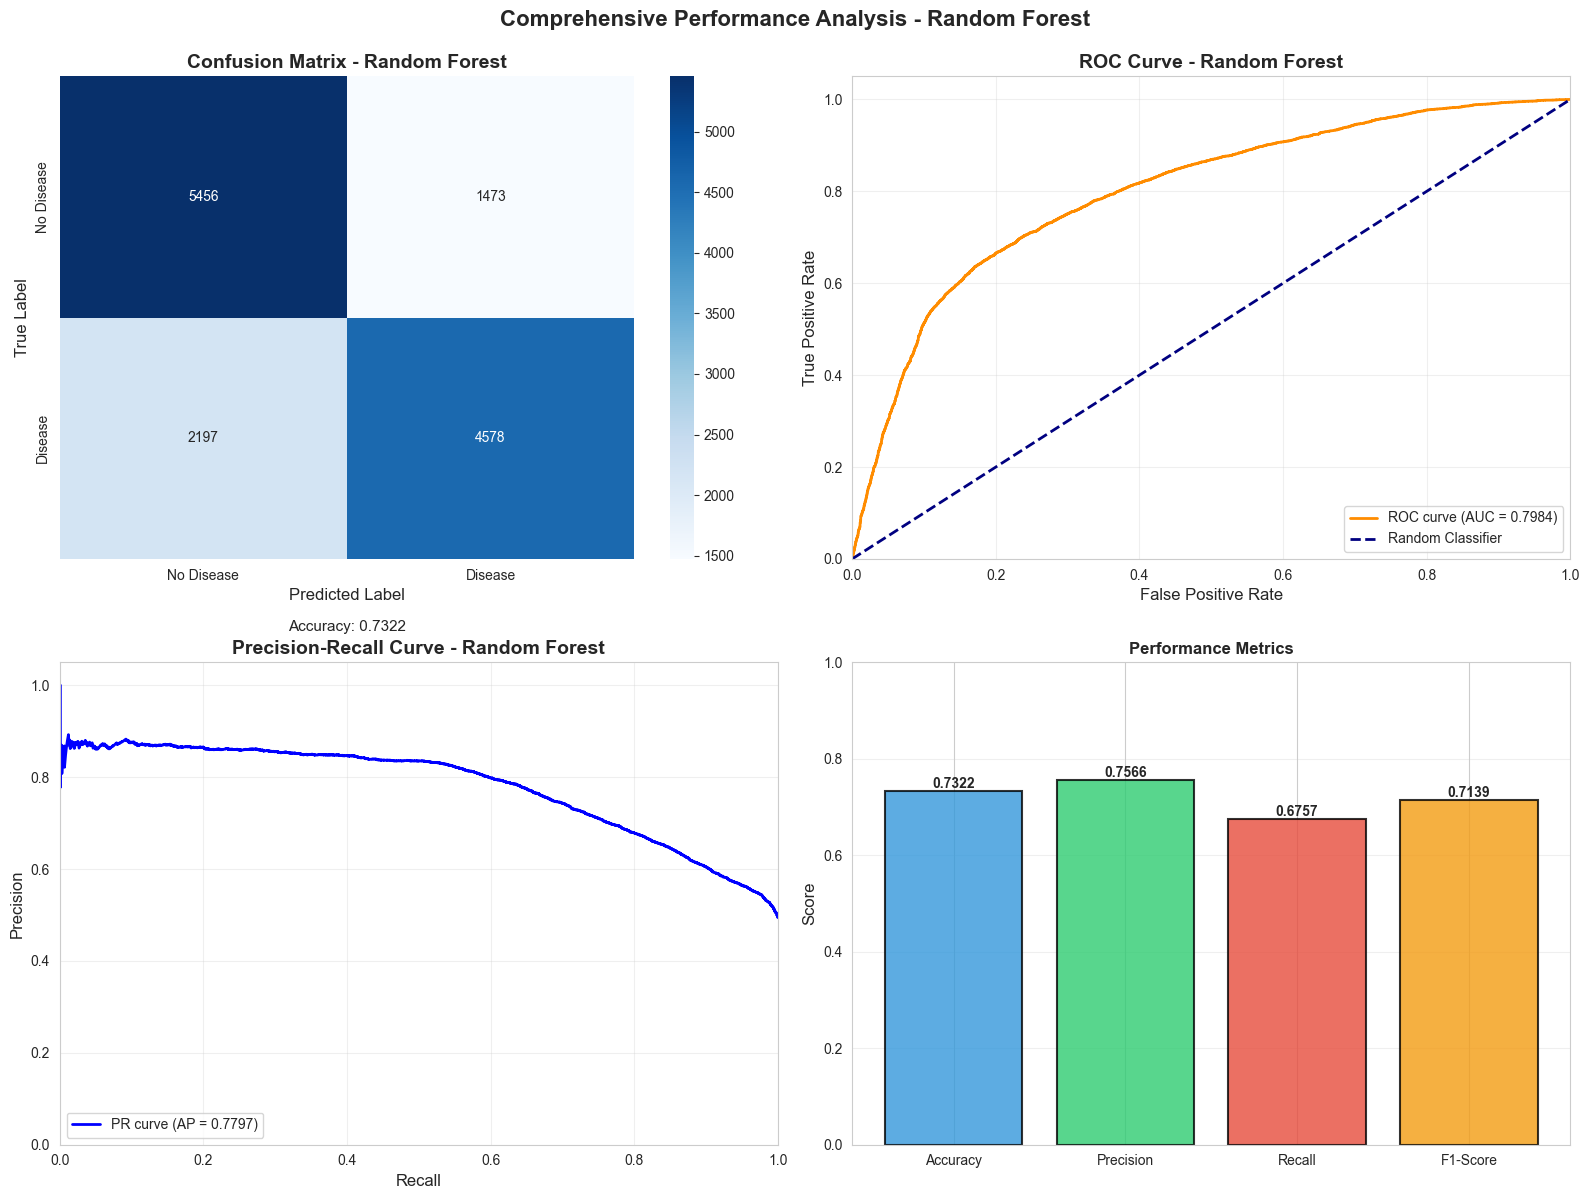

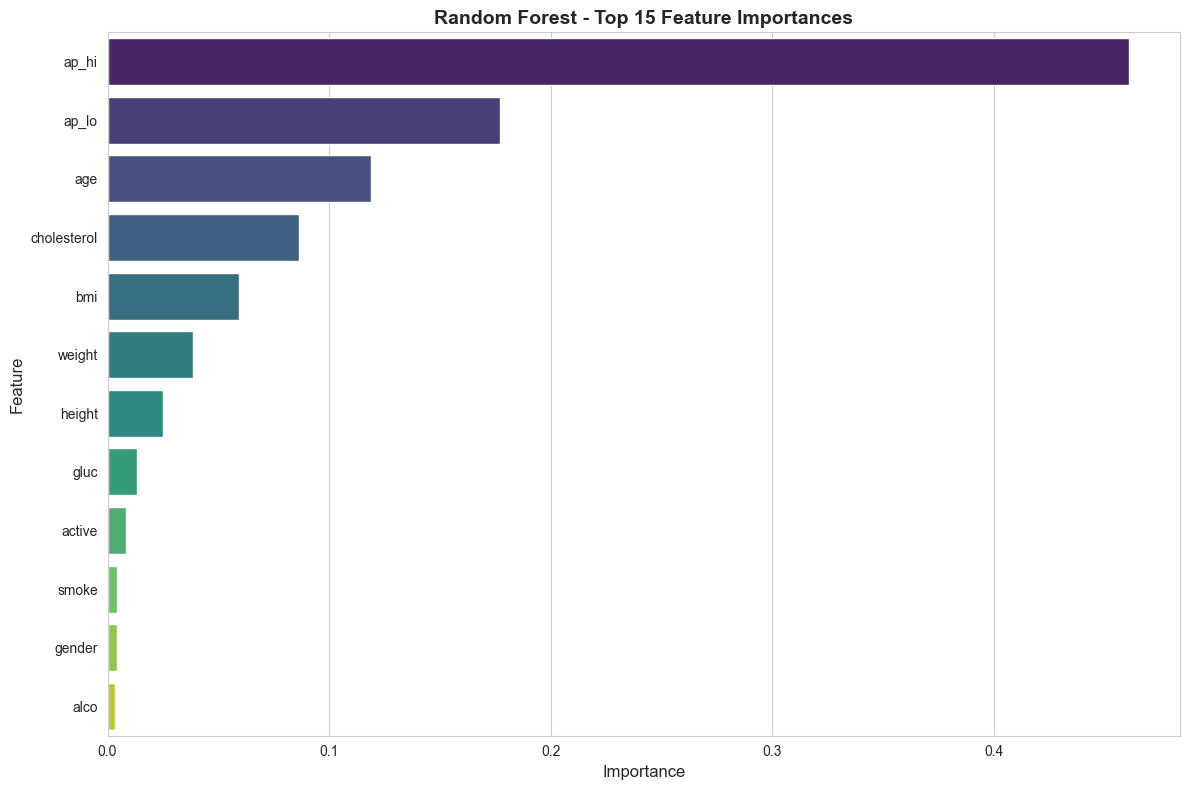


=== Random Forest Performance Summary ===
Accuracy:  0.7322
Precision: 0.7566
Recall:    0.6757
F1-Score:  0.7139


In [ ]:
# Train Random Forest and generate visualizations
rf_classifier = CardioRandomForestClassifier(
    test_size=0.2,
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

# Load and train
rf_classifier.load_data('train.csv')
rf_classifier.preprocess_data()
rf_classifier.train()

# Evaluate to get metrics
rf_classifier.evaluate()

# Get predictions and probabilities
y_pred_rf = rf_classifier.model.predict(rf_classifier.X_test)
y_proba_rf = rf_classifier.model.predict_proba(rf_classifier.X_test)[:, 1]

# Get metrics
rf_metrics = rf_classifier.metrics

# Create comprehensive performance visualization
fig = plot_classifier_performance_grid(
    rf_classifier.y_test, y_pred_rf, y_proba_rf, 
    rf_metrics, 'Random Forest'
)
plt.savefig('Figures/RandomForest_Performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance for Random Forest
if hasattr(rf_classifier.model, 'feature_importances_'):
    fig, ax = plt.subplots(figsize=(12, 8))
    feature_importance = pd.DataFrame({
        'feature': rf_classifier.feature_names,
        'importance': rf_classifier.model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    sns.barplot(data=feature_importance, x='importance', y='feature', 
                palette='viridis', ax=ax)
    ax.set_title('Random Forest - Top 15 Feature Importances', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig('Figures/RandomForest_FeatureImportance.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n=== Random Forest Performance Summary ===")
print(f"Accuracy:  {rf_metrics['accuracy']:.4f}")
print(f"Precision: {rf_metrics['precision']:.4f}")
print(f"Recall:    {rf_metrics['recall']:.4f}")
print(f"F1-Score:  {rf_metrics['f1_score']:.4f}")

## 4. Naive Bayes - Performance Visualization

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7072
Precision: 0.7501
Recall:    0.6114
F1-Score:  0.6737

Confusion Matrix:
[[5549 1380]
 [2633 4142]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.68      0.80      0.73      6929
     Disease       0.75      0.61      0.67      6775

    accuracy                           0.71     13704
   macro avg       0.71      0.71      0.70     13704
weighted avg       0.71      0.71      0.70     13704




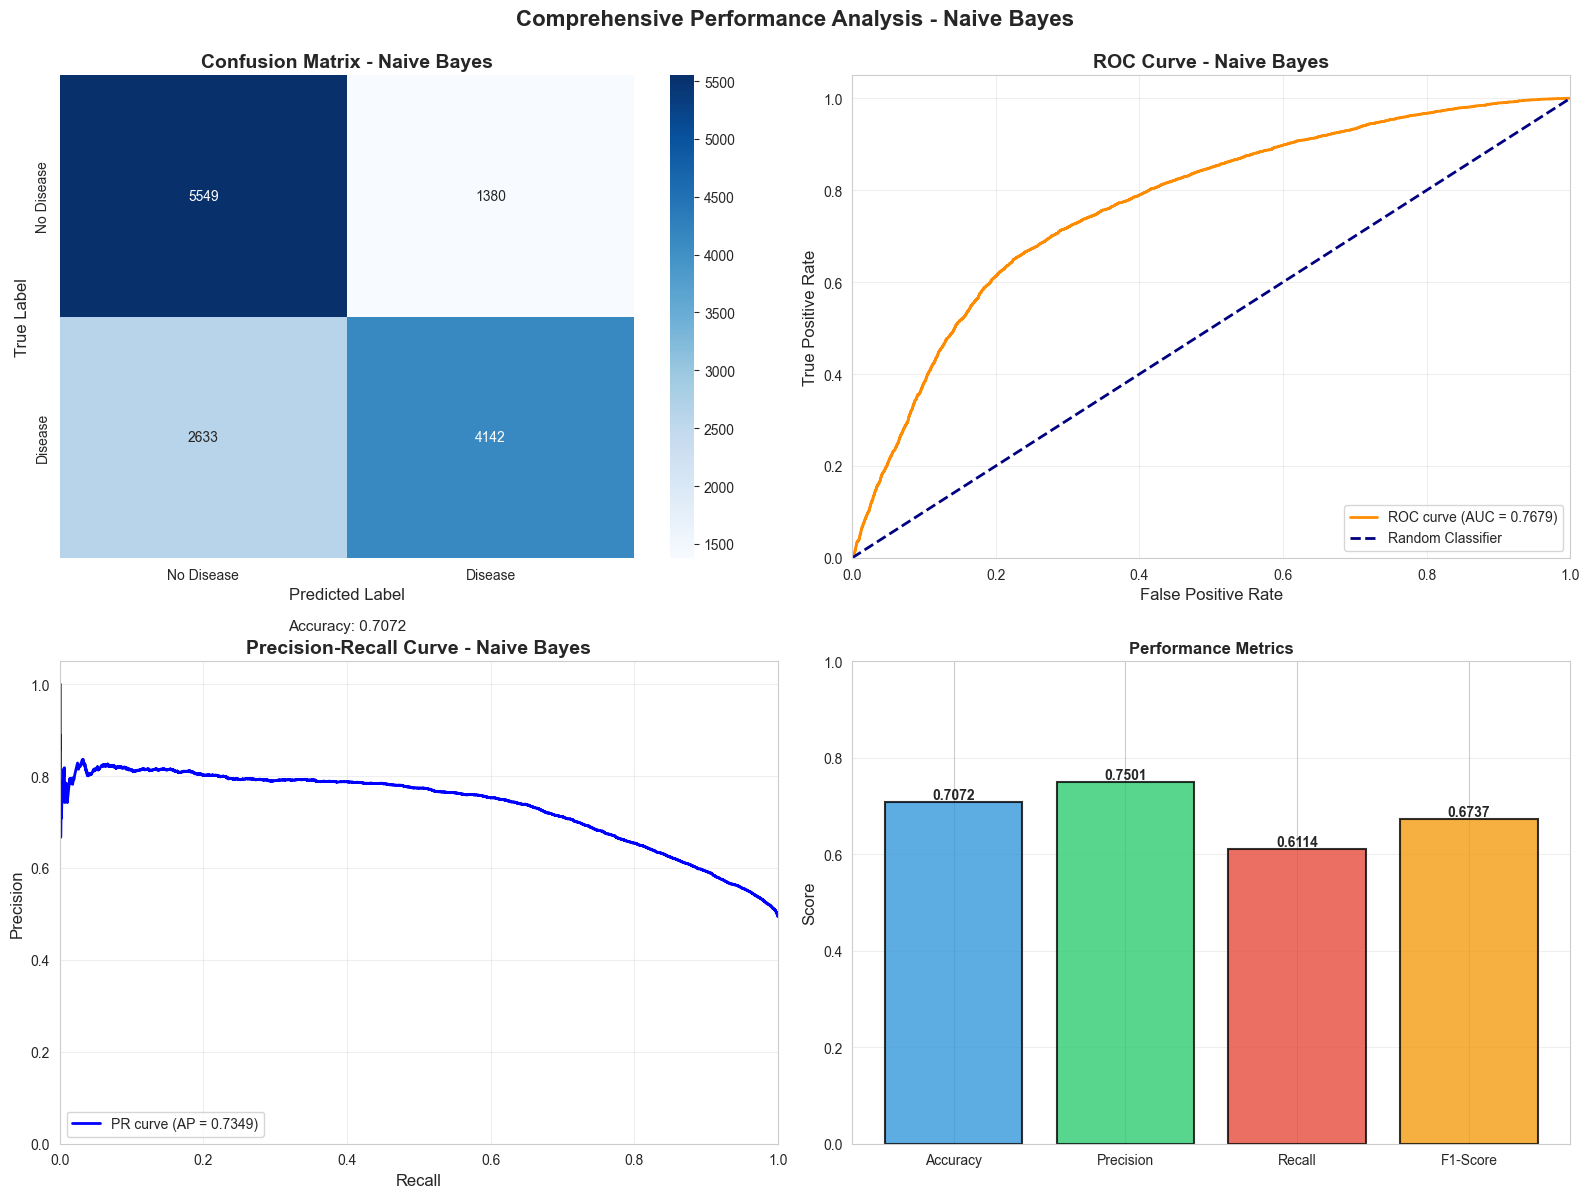


=== Naive Bayes Performance Summary ===
Accuracy:  0.7072
Precision: 0.7501
Recall:    0.6114
F1-Score:  0.6737


In [ ]:
# Train Naive Bayes and generate visualizations
nb_classifier = CardioNaiveBayesClassifier(
    test_size=0.2,
    random_state=42,
    scale_features=True
)

# Load and train
nb_classifier.load_data('train.csv')
nb_classifier.preprocess_data()
nb_classifier.train()

# Evaluate to get metrics
nb_classifier.evaluate()

# Get predictions and probabilities
y_pred_nb = nb_classifier.model.predict(nb_classifier.X_test)
y_proba_nb = nb_classifier.model.predict_proba(nb_classifier.X_test)[:, 1]

# Get metrics
nb_metrics = nb_classifier.metrics

# Create comprehensive performance visualization
fig = plot_classifier_performance_grid(
    nb_classifier.y_test, y_pred_nb, y_proba_nb, 
    nb_metrics, 'Naive Bayes'
)
plt.savefig('Figures/NaiveBayes_Performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Naive Bayes Performance Summary ===")
print(f"Accuracy:  {nb_metrics['accuracy']:.4f}")
print(f"Precision: {nb_metrics['precision']:.4f}")
print(f"Recall:    {nb_metrics['recall']:.4f}")
print(f"F1-Score:  {nb_metrics['f1_score']:.4f}")

## 5. Gradient Boosting - Performance Visualization

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7331
Precision: 0.7526
Recall:    0.6855
F1-Score:  0.7174

Confusion Matrix:
[[5402 1527]
 [2131 4644]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.72      0.78      0.75      6929
     Disease       0.75      0.69      0.72      6775

    accuracy                           0.73     13704
   macro avg       0.73      0.73      0.73     13704
weighted avg       0.73      0.73      0.73     13704


Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7331
Precision: 0.7526
Recall:    0.6855
F1-Score:  0.7174

Confusion Matrix:
[[5402 1527]
 [2131 4644]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.72      0.78      0.75      6929
     Disease       0.75      0.69      0.72      6775

    accu

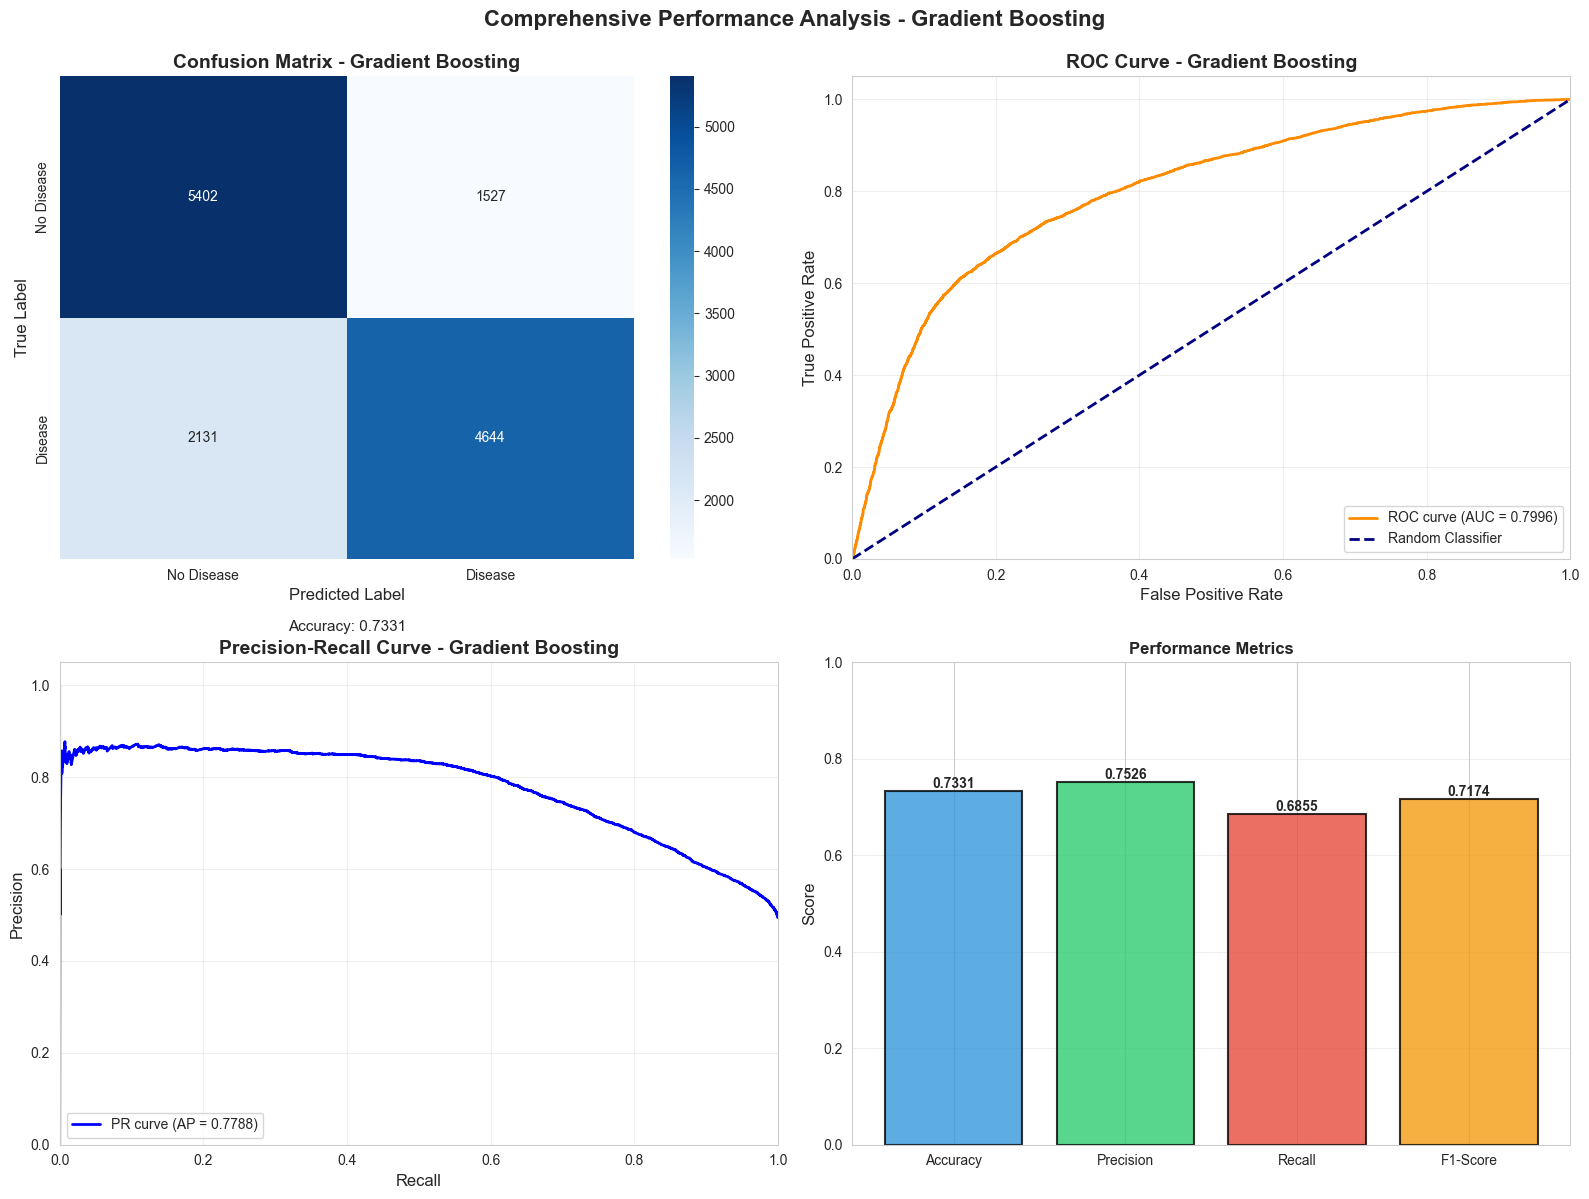

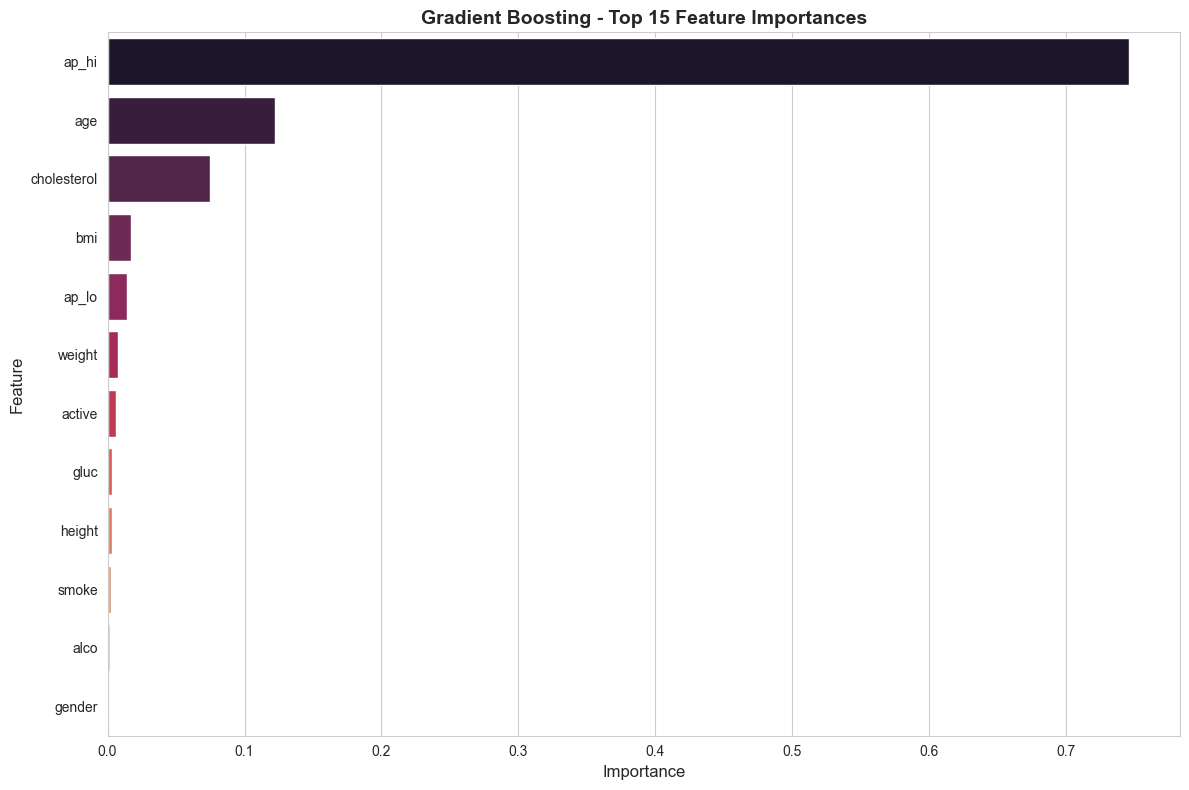


=== Gradient Boosting Performance Summary ===
Accuracy:  0.7331
Precision: 0.7526
Recall:    0.6855
F1-Score:  0.7174


In [ ]:
# Train Gradient Boosting and generate visualizations
gb_classifier = CardioGradientBoostingClassifier(
    test_size=0.2,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    scale_features=True
)

# Load and train
gb_classifier.load_data('train.csv')
gb_classifier.preprocess_data()
gb_classifier.train()

# Evaluate to get metrics
gb_classifier.evaluate()

# Get predictions and probabilities
y_pred_gb = gb_classifier.model.predict(gb_classifier.X_test)
y_proba_gb = gb_classifier.model.predict_proba(gb_classifier.X_test)[:, 1]

# Get metrics
gb_metrics = gb_classifier.metrics

# Create comprehensive performance visualization
fig = plot_classifier_performance_grid(
    gb_classifier.y_test, y_pred_gb, y_proba_gb, 
    gb_metrics, 'Gradient Boosting'
)
plt.savefig('Figures/GradientBoosting_Performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance for Gradient Boosting
if hasattr(gb_classifier.model, 'feature_importances_'):
    fig, ax = plt.subplots(figsize=(12, 8))
    feature_importance = pd.DataFrame({
        'feature': gb_classifier.feature_names,
        'importance': gb_classifier.model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    sns.barplot(data=feature_importance, x='importance', y='feature', 
                palette='rocket', ax=ax)
    ax.set_title('Gradient Boosting - Top 15 Feature Importances', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig('Figures/GradientBoosting_FeatureImportance.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n=== Gradient Boosting Performance Summary ===")
print(f"Accuracy:  {gb_metrics['accuracy']:.4f}")
print(f"Precision: {gb_metrics['precision']:.4f}")
print(f"Recall:    {gb_metrics['recall']:.4f}")
print(f"F1-Score:  {gb_metrics['f1_score']:.4f}")

## 6. SVM - Performance Visualization

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7328
Precision: 0.7605
Recall:    0.6707
F1-Score:  0.7128

Confusion Matrix:
[[5498 1431]
 [2231 4544]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.79      0.75      6929
     Disease       0.76      0.67      0.71      6775

    accuracy                           0.73     13704
   macro avg       0.74      0.73      0.73     13704
weighted avg       0.74      0.73      0.73     13704



MODEL PERFORMANCE METRICS
Accuracy:  0.7328
Precision: 0.7605
Recall:    0.6707
F1-Score:  0.7128

Confusion Matrix:
[[5498 1431]
 [2231 4544]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.79      0.75      6929
     Disease       0.76      0.67      0.71      6775

    accu

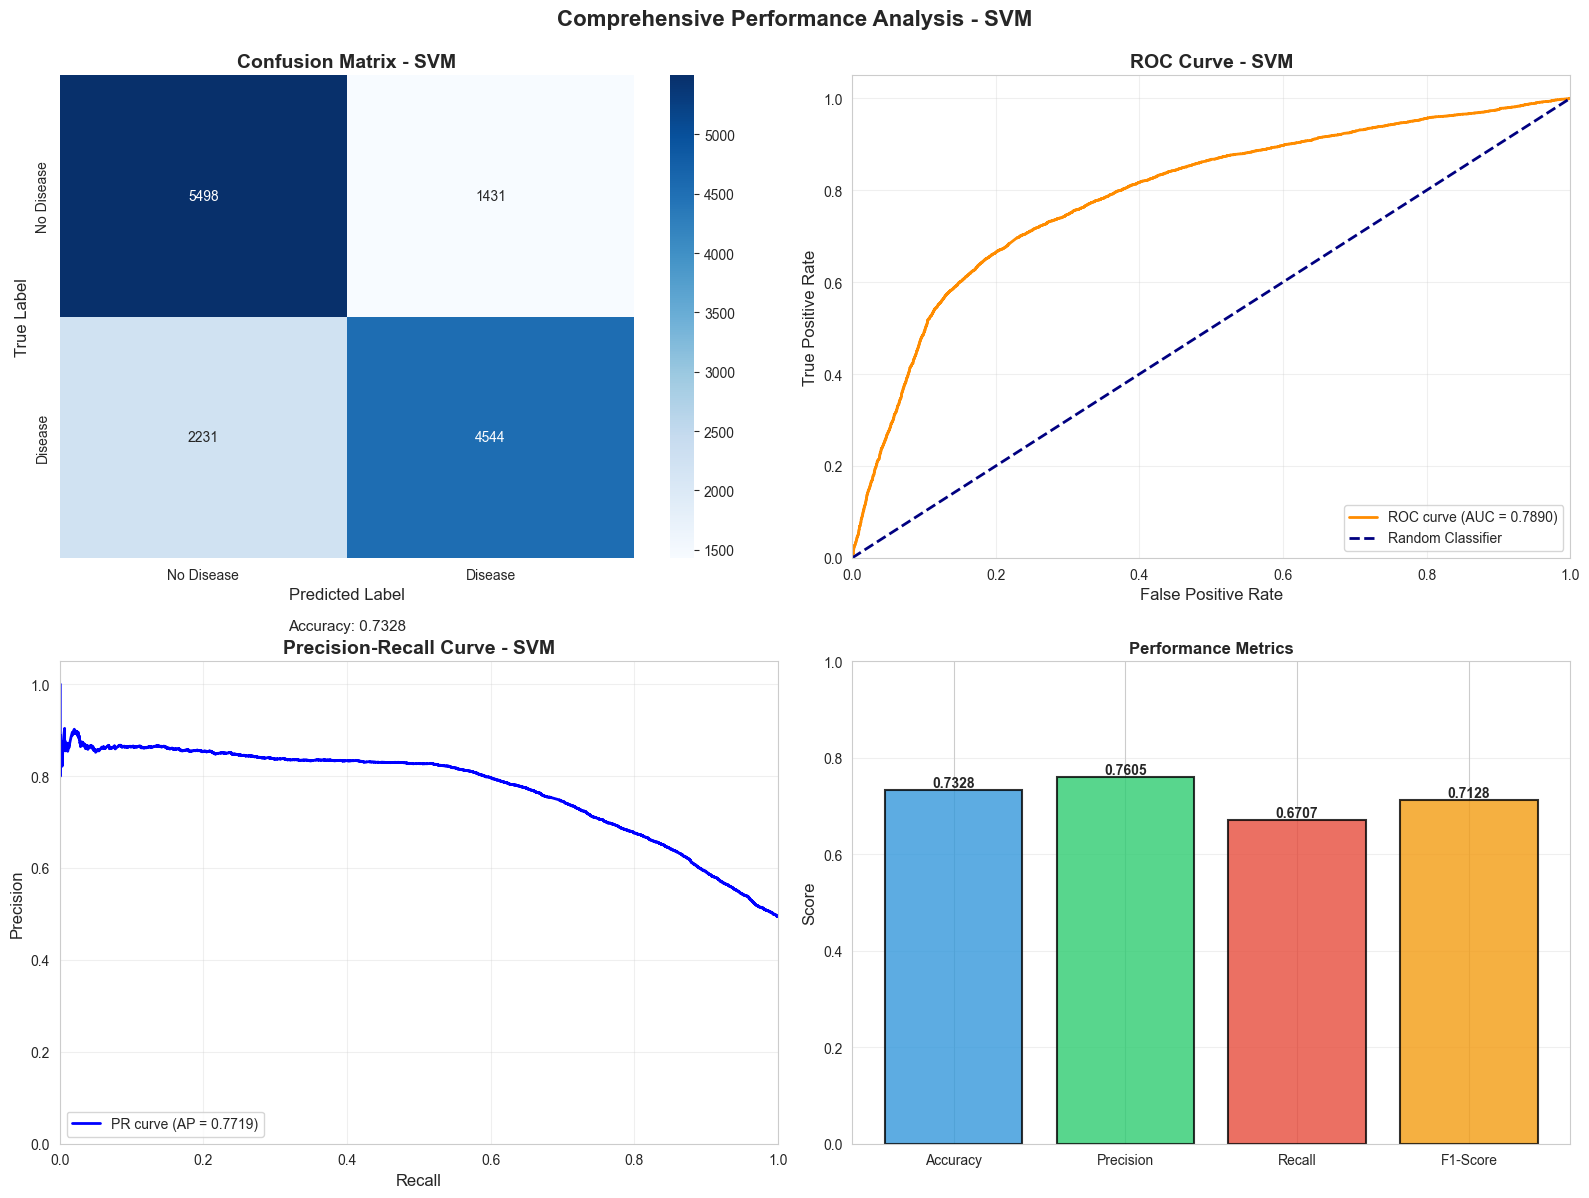


=== SVM Performance Summary ===
Accuracy:  0.7328
Precision: 0.7605
Recall:    0.6707
F1-Score:  0.7128


In [ ]:
# Train SVM and generate visualizations
svm_classifier = CardioSupportVectorClassifier(
    test_size=0.2,
    random_state=42,
    kernel='rbf',
    C=1.0,
    gamma='scale',
    scale_features=True
)

# Load and train
svm_classifier.load_data('train.csv')
svm_classifier.preprocess_data()
svm_classifier.train()

# Evaluate to get metrics
svm_classifier.evaluate()

# Get predictions
# Note: SVM without probability=True doesn't support predict_proba, so we'll use decision_function
y_pred_svm = svm_classifier.model.predict(svm_classifier.X_test)

# For ROC and PR curves, we need probability scores
# We'll retrain with probability=True for visualization purposes
from sklearn.svm import SVC
svm_prob_model = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    random_state=42,
    probability=True
)
svm_prob_model.fit(svm_classifier.X_train, svm_classifier.y_train)
y_proba_svm = svm_prob_model.predict_proba(svm_classifier.X_test)[:, 1]

# Get metrics
svm_metrics = svm_classifier.metrics

# Create comprehensive performance visualization
fig = plot_classifier_performance_grid(
    svm_classifier.y_test, y_pred_svm, y_proba_svm, 
    svm_metrics, 'SVM'
)
plt.savefig('Figures/SVM_Performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== SVM Performance Summary ===")
print(f"Accuracy:  {svm_metrics['accuracy']:.4f}")
print(f"Precision: {svm_metrics['precision']:.4f}")
print(f"Recall:    {svm_metrics['recall']:.4f}")
print(f"F1-Score:  {svm_metrics['f1_score']:.4f}")

## 7. KNN - Performance Visualization

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.6898
Precision: 0.6913
Recall:    0.6732
F1-Score:  0.6821

Confusion Matrix:
[[4892 2037]
 [2214 4561]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.69      0.71      0.70      6929
     Disease       0.69      0.67      0.68      6775

    accuracy                           0.69     13704
   macro avg       0.69      0.69      0.69     13704
weighted avg       0.69      0.69      0.69     13704



MODEL PERFORMANCE METRICS
Accuracy:  0.6898
Precision: 0.6913
Recall:    0.6732
F1-Score:  0.6821

Confusion Matrix:
[[4892 2037]
 [2214 4561]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.69      0.71      0.70      6929
     Disease       0.69      0.67      0.68      6775

    accu

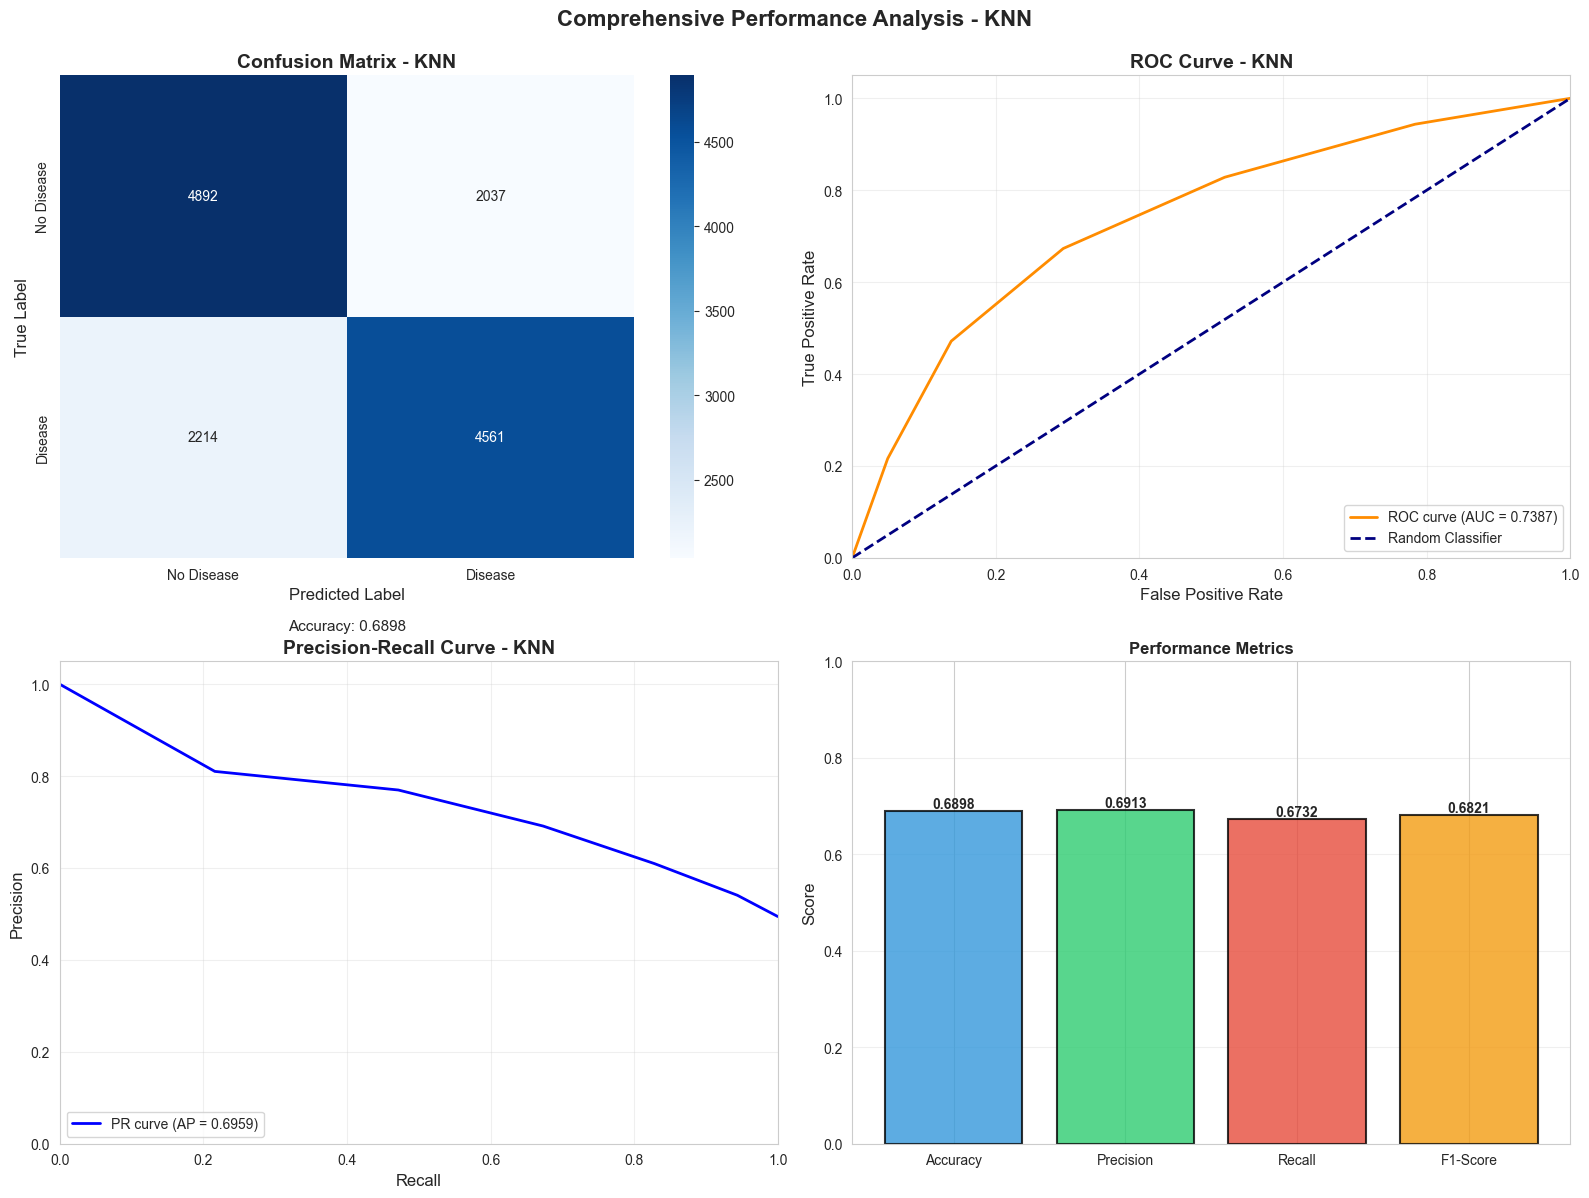


=== KNN Performance Summary ===
Accuracy:  0.6898
Precision: 0.6913
Recall:    0.6732
F1-Score:  0.6821


In [ ]:
# Train KNN and generate visualizations
knn_classifier = CardioKNeighborsClassifier(
    test_size=0.2,
    random_state=42,
    n_neighbors=5,
    scale_features=True
)

# Load and train
knn_classifier.load_data('train.csv')
knn_classifier.preprocess_data()
knn_classifier.train()

# Evaluate to get metrics
knn_classifier.evaluate()

# Get predictions and probabilities
y_pred_knn = knn_classifier.model.predict(knn_classifier.X_test)
y_proba_knn = knn_classifier.model.predict_proba(knn_classifier.X_test)[:, 1]

# Get metrics
knn_metrics = knn_classifier.metrics

# Create comprehensive performance visualization
fig = plot_classifier_performance_grid(
    knn_classifier.y_test, y_pred_knn, y_proba_knn, 
    knn_metrics, 'KNN'
)
plt.savefig('Figures/KNN_Performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== KNN Performance Summary ===")
print(f"Accuracy:  {knn_metrics['accuracy']:.4f}")
print(f"Precision: {knn_metrics['precision']:.4f}")
print(f"Recall:    {knn_metrics['recall']:.4f}")
print(f"F1-Score:  {knn_metrics['f1_score']:.4f}")

## 8. All Classifiers - Comprehensive Comparison

In [ ]:
# Collect all metrics for comparison
all_metrics = {
    'Decision Tree': dt_metrics,
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'Naive Bayes': nb_metrics,
    'Gradient Boosting': gb_metrics,
    'SVM': svm_metrics,
    'KNN': knn_metrics
}

# Create comparison dataframe
comparison_data = []
for model_name, metrics in all_metrics.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': get_metric_value(metrics, 'accuracy'),
        'Precision': get_metric_value(metrics, 'precision'),
        'Recall': get_metric_value(metrics, 'recall'),
        'F1-Score': get_metric_value(metrics, 'f1_score')
    })

comparison_df = pd.DataFrame(comparison_data)
print("=== Model Performance Comparison ===")
print(comparison_df.to_string(index=False))
print("\n")

=== Model Performance Comparison ===
              Model  Accuracy  Precision   Recall  F1-Score
      Decision Tree  0.721687   0.732673 0.688118  0.709697
Logistic Regression  0.726795   0.753640 0.664649  0.706353
      Random Forest  0.732195   0.756569 0.675720  0.713862
        Naive Bayes  0.707166   0.750091 0.611365  0.673660
  Gradient Boosting  0.733071   0.752552 0.685461  0.717442
                SVM  0.732779   0.760502 0.670701  0.712784
                KNN  0.689799   0.691270 0.673210  0.682121




In [ ]:
# Create comprehensive comparison visualizations

# 1. Performance Metrics Bar Chart Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('All Classifiers - Performance Metrics Comparison', 
             fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    sorted_df = comparison_df.sort_values(metric, ascending=False)
    bars = ax.barh(sorted_df['Model'], sorted_df[metric], color=color, alpha=0.8, 
                   edgecolor='black', linewidth=1.5)
    
    ax.set_xlim([0, 1])
    ax.set_xlabel('Score', fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar, value in zip(bars, sorted_df[metric]):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{value:.4f}',
                ha='left', va='center', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('Figures/All_Classifiers_Metrics_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 2. Grouped Bar Chart - All Metrics Together
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(comparison_df))
width = 0.2

bars1 = ax.bar(x - 1.5*width, comparison_df['Accuracy'], width, 
               label='Accuracy', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x - 0.5*width, comparison_df['Precision'], width, 
               label='Precision', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + 0.5*width, comparison_df['Recall'], width, 
               label='Recall', color='#e74c3c', alpha=0.8, edgecolor='black')
bars4 = ax.bar(x + 1.5*width, comparison_df['F1-Score'], width, 
               label='F1-Score', color='#f39c12', alpha=0.8, edgecolor='black')

ax.set_xlabel('Classifier', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('All Classifiers - Performance Metrics Grouped Comparison', 
             fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim([0, 1.05])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('Figures/All_Classifiers_Grouped_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 3. Radar Chart - Multi-dimensional Performance Comparison
from math import pi

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

colors = plt.cm.Set3(np.linspace(0, 1, len(comparison_df)))

for idx, (_, row) in enumerate(comparison_df.iterrows()):
    values = [row['Accuracy'], row['Precision'], row['Recall'], row['F1-Score']]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_title('All Classifiers - Radar Chart Performance Comparison', 
             size=15, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig('Figures/All_Classifiers_Radar_Chart.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'comparison_df' is not defined

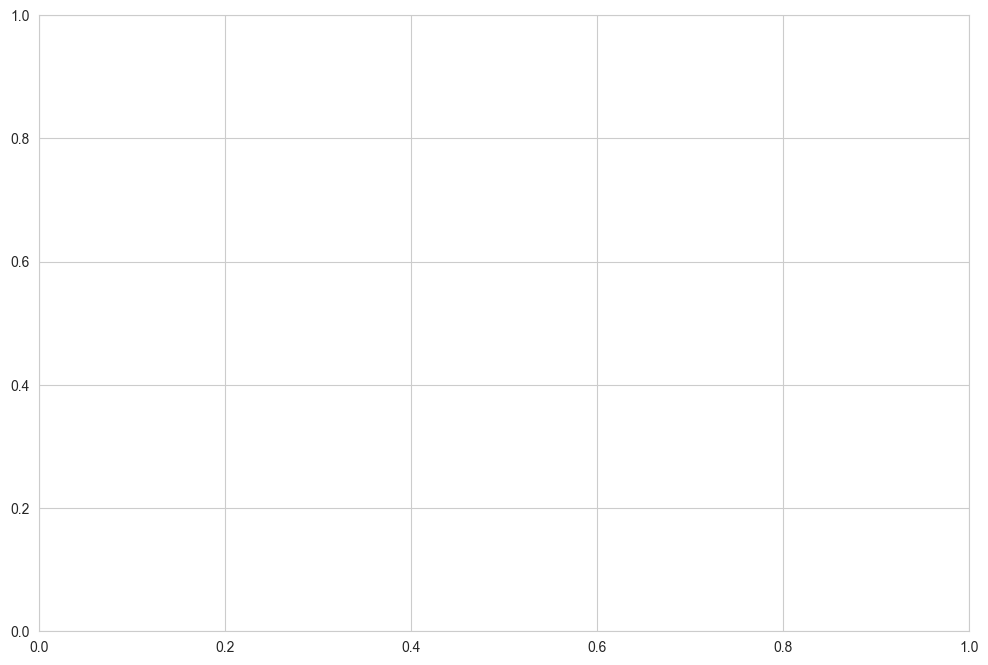

In [ ]:
# 4. Heatmap - Performance Metrics Matrix
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = comparison_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']]

sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray',
            vmin=0, vmax=1, ax=ax)

ax.set_title('All Classifiers - Performance Metrics Heatmap', 
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Metrics', fontsize=13, fontweight='bold')
ax.set_ylabel('Classifier', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('Figures/All_Classifiers_Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 5. ROC Curves - All Classifiers Comparison
fig, ax = plt.subplots(figsize=(12, 10))

# Store all classifier data for ROC comparison
classifiers_data = [
    ('Decision Tree', dt_classifier.y_test, y_proba, '#3498db'),
    ('Logistic Regression', lr_classifier.y_test, y_proba_lr, '#2ecc71'),
    ('Random Forest', rf_classifier.y_test, y_proba_rf, '#e74c3c'),
    ('Naive Bayes', nb_classifier.y_test, y_proba_nb, '#f39c12'),
    ('Gradient Boosting', gb_classifier.y_test, y_proba_gb, '#9b59b6'),
    ('SVM', svm_classifier.y_test, y_proba_svm, '#1abc9c'),
    ('KNN', knn_classifier.y_test, y_proba_knn, '#e67e22')
]

for name, y_true, y_prob, color in classifiers_data:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2.5, label=f'{name} (AUC = {roc_auc:.4f})', color=color)

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves - All Classifiers Comparison', fontsize=15, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Figures/All_Classifiers_ROC_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 6. Precision-Recall Curves - All Classifiers Comparison
fig, ax = plt.subplots(figsize=(12, 10))

for name, y_true, y_prob, color in classifiers_data:
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    avg_precision = average_precision_score(y_true, y_prob)
    ax.plot(recall, precision, lw=2.5, 
            label=f'{name} (AP = {avg_precision:.4f})', color=color)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.set_title('Precision-Recall Curves - All Classifiers Comparison', 
             fontsize=15, fontweight='bold')
ax.legend(loc="lower left", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Figures/All_Classifiers_PR_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 7. Summary Statistics and Rankings
print("\n" + "="*70)
print("COMPREHENSIVE PERFORMANCE ANALYSIS - SUMMARY")
print("="*70)

# Best model for each metric
print("\n📊 BEST PERFORMER FOR EACH METRIC:")
print("-" * 70)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_model = comparison_df.loc[comparison_df[metric].idxmax()]
    print(f"{metric:15s}: {best_model['Model']:25s} ({best_model[metric]:.4f})")

# Overall ranking based on F1-Score
print("\n🏆 OVERALL RANKING (Based on F1-Score):")
print("-" * 70)
sorted_models = comparison_df.sort_values('F1-Score', ascending=False)
for idx, (_, row) in enumerate(sorted_models.iterrows(), 1):
    print(f"{idx}. {row['Model']:25s} - F1: {row['F1-Score']:.4f}, Acc: {row['Accuracy']:.4f}")

# Statistical summary
print("\n📈 STATISTICAL SUMMARY:")
print("-" * 70)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    values = comparison_df[metric]
    print(f"{metric:15s}: Mean={values.mean():.4f}, Std={values.std():.4f}, "
          f"Min={values.min():.4f}, Max={values.max():.4f}")

print("\n" + "="*70)
print("VISUALIZATION COMPLETE - All graphs saved to 'Figures/' directory")
print("="*70)

## Summary

This comprehensive performance analysis includes:

### Individual Classifier Visualizations:
1. **Decision Tree** - Confusion Matrix, ROC Curve, Precision-Recall Curve, Metrics Bar Chart
2. **Logistic Regression** - Complete performance visualization grid
3. **Random Forest** - Performance grid + Feature Importance analysis
4. **Naive Bayes** - Complete performance visualization grid
5. **Gradient Boosting** - Performance grid + Feature Importance analysis
6. **SVM** - Complete performance visualization grid
7. **KNN** - Complete performance visualization grid

### Comparative Analysis:
- **Metrics Comparison**: Bar charts comparing Accuracy, Precision, Recall, and F1-Score
- **Grouped Bar Chart**: All metrics side-by-side comparison
- **Radar Chart**: Multi-dimensional performance visualization
- **Heatmap**: Color-coded performance matrix
- **ROC Curves**: All classifiers on a single plot for AUC comparison
- **Precision-Recall Curves**: All classifiers comparison for imbalanced data performance

All visualizations are saved in the `Figures/` directory with high resolution (300 DPI) for publication quality.